In [43]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.linalg import eigh
import matplotlib as mpl
from scipy.stats import chi2
from adjustText import adjust_text
from matplotlib.colors import to_rgba

In [15]:
mpl.rcParams['font.family'] = 'Arial'

In [16]:
df = pd.read_csv(r"C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\Data\raw_pca_data.csv")
print(df.head(2))
df.replace(' ', np.nan, inplace=True)
numerical_data = df.iloc[:, 3:]

  Plant Species Compound Functional Group  Molecular Weight (g/mol)   pKa  \
0       Lettuce     PFBA      Carboxylate                     214.1 -0.21   
1       Lettuce     PFBA      Carboxylate                     214.1 -0.21   

   log Kow   Exposure time  (hrs)  RCF (L/g)  SCF (L/g)      TF  
0     1.43                    960      0.030         0.03  1.00  
1     1.43                    960      0.009         0.02  2.22  


**Impute Missing Values**

In [17]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numerical_data_imputed = imputer.fit_transform(numerical_data)
numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns)
df_imputed = pd.concat([df.iloc[:, :3], numerical_data_imputed], axis=1)
#output_file_imputed = r'C:\Users\白猪白猪\Documents\Documents\CMSE802\Class_Material\Homework\Project\imputed_pca_data.csv'
#df_imputed.to_csv(output_file_imputed, index=False)

**Scale the imputed numerical data**

In [18]:
scaler = MinMaxScaler().set_output(transform="pandas")
df_scaled = scaler.fit_transform(numerical_data_imputed)
df_scaled = pd.DataFrame(df_scaled, columns=numerical_data_imputed.columns)

**Perform PCA**

In [19]:
# Apply PCA to reduce the dimensionality of the scaled data to 4 principal components
pca_easy = PCA(n_components=4)
df_reduced = pca_easy.fit_transform(df_scaled)
# Create DataFrame for Reduced Data
df_reduced = pd.DataFrame(df_reduced, columns=['PC1', 'PC2', 'PC3', 'PC4'])

**Add Category Information**

In [64]:
# Add the categorical variable to the reduced data DataFrame for plotting
# Columns 0-2 are categorical variables
#categories = df.iloc[:, 1]
#categories = df.iloc[:, 2]
categories = df.iloc[:, 0]
df_reduced['Category'] = categories

#print("Data shape before PCA:", numerical_data.shape)
#print("Data shape after PCA:", df_reduced.shape)

**Print Explained Variance by Each Principal Component**

In [60]:
for i, exp_var in enumerate(pca_easy.explained_variance_ratio_, start=1):
    print(f"Component {i}: {exp_var*100:.2f}%")

Component 1: 46.94%
Component 2: 21.71%
Component 3: 19.87%
Component 4: 4.80%


**Calculate Total Variance Explained**

In [61]:
# Sum the eigenvalues
total_variance = sum(pca_easy.explained_variance_ratio_)
print(f"Total variance explained: {total_variance*100:.2f}%")

Total variance explained: 93.33%


**Create Loadings DataFrame**

In [62]:
loadings = pca_easy.components_.T
loading_df = pd.DataFrame(loadings, index=numerical_data.columns, columns=['PC1', 'PC2','PC3', 'PC4'])
print("\nLoading Table:")
print(loading_df)


Loading Table:
                               PC1       PC2       PC3       PC4
Molecular Weight (g/mol)  0.652745 -0.068134 -0.063361  0.275962
pKa                       0.247725 -0.053270  0.957153 -0.049226
log Kow                   0.706792  0.007172 -0.276509 -0.322793
 Exposure time  (hrs)     0.057378  0.992673  0.047811  0.034388
RCF (L/g)                 0.093787 -0.020171 -0.030259  0.602329
SCF (L/g)                 0.001515 -0.002273 -0.011752  0.672804
TF                       -0.030170  0.081590  0.006816 -0.024053


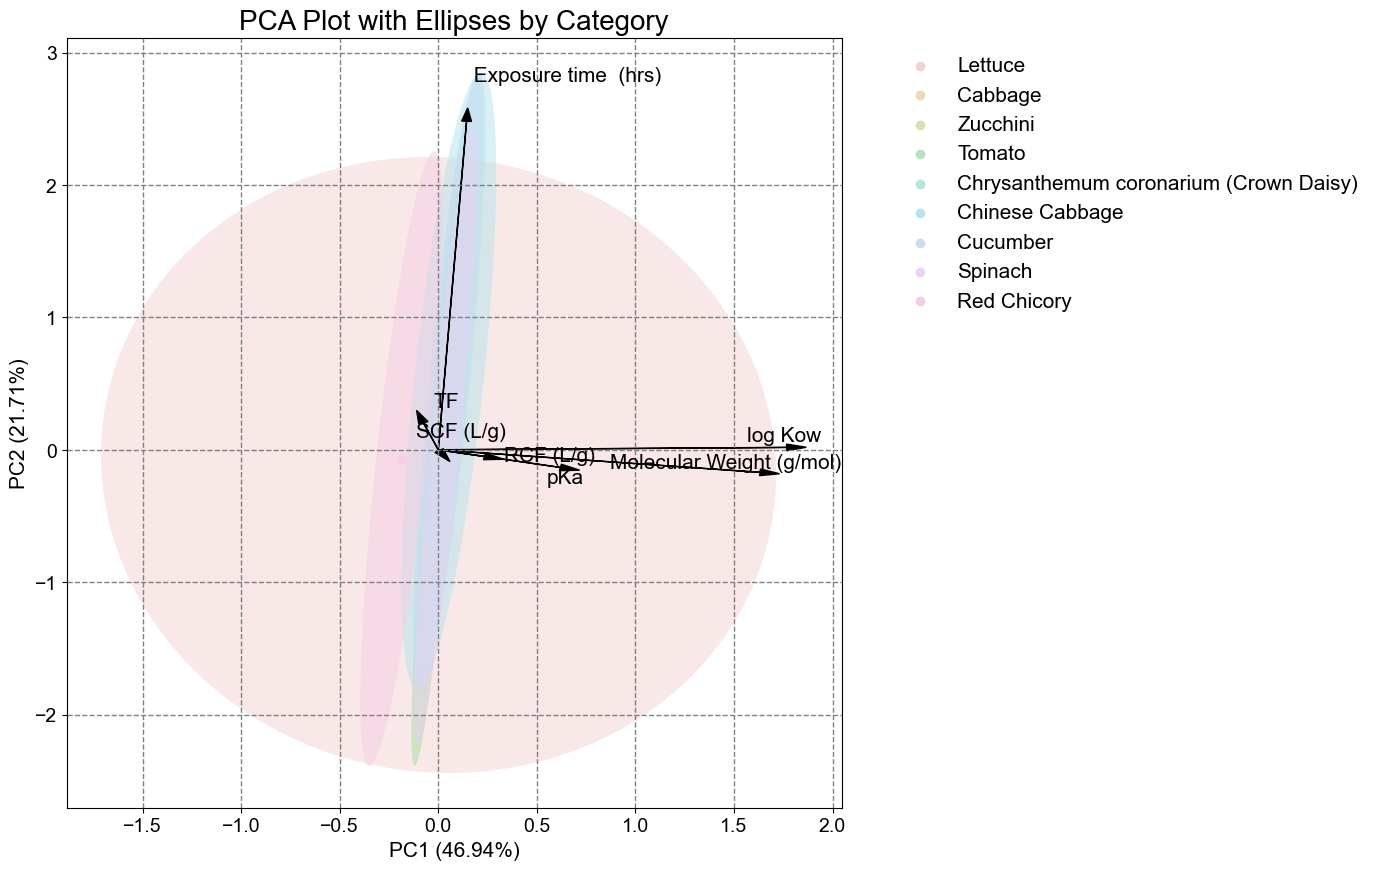

In [65]:
# Create a list of hex color codes
plt.figure(figsize=(10,10))
plt.title('PCA Plot with Ellipses by Category', fontsize=20)

colors = ['#F3D3D0', '#EADAB5',  '#DAE0B5', '#B5E4C3', '#B5E5DD', '#B5E3EE', '#CDDCF5', '#ECD2F4',
          '#F5CDE6', '#F3D3D0',  '#EADAB5', '#DAE0B5', '#B5E4C3', '#B5E5DD', '#B5E3EE','#CDDCF5','#ECD2F4',
          '#F5CDE6','#F3D3D0']
# Extract the unique categories from the 'Category'
unique_categories = df_reduced['Category'].unique()
# Set the significance level (70% confidence interval)
alpha = 0.3
# Compute the critical value for a chi-squared distribution with 2 degrees of freedom at the 70% confidence level 
critical_value = chi2.ppf(1 - alpha, df=2) 
for i, category in enumerate(unique_categories):
    category_data = df_reduced[df_reduced['Category'] == category]
    cov = np.cov(category_data[['PC1', 'PC2']].values.T) #Compute the covariance matrix for the 'PC1' and 'PC2' values of the current category
    values, vectors = eigh(cov) # Perform an eigenvalue decomposition on the covariance matrix to obtain the eigenvalues and eigenvectors.
    scale_factor = np.sqrt(critical_value / values[-1]) #Compute a scale factor based on the critical value and the smallest eigenvalue
    width, height = 3 * scale_factor * np.sqrt(values[-1]), 3 * scale_factor * np.sqrt(values[0]) # Calculate the width and height of the ellipse
    angle = np.degrees(np.arctan2(vectors[1, 0], vectors[0, 0])) # Determine the angle of the ellipse
    #Calculate the mean values of 'PC1' and 'PC2' for the current category, which will be the center of the ellipse
    mean = [category_data['PC1'].mean(), category_data['PC2'].mean()]


    edge_color = to_rgba(colors[i], alpha=0)
    face_color = to_rgba(colors[i], alpha=0.5)
    # Create Ellipse with edgecolor the same as facecolor but with specified alpha for edge
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=edge_color, facecolor=face_color, lw=1,  fill=True)
    # Add Ellipse to Plot
    plt.gca().add_patch(ell)
    # using the color from the color palette and labeling it with the category name
    plt.scatter(mean[0], mean[1], color=colors[i % len(colors)], label=category)

# Add Loading Arrows to Represent the Loadings of the Variables
loadings = pca_easy.components_
texts = []
for i, loading in enumerate(loadings.T):
    plt.arrow(0, 0, loading[0]*2.5, loading[1]*2.5, head_width=0.05, head_length=0.1, fc='k', ec='k')
    #plt.text(loading[0]*1.1*2, loading[1]*1.1*2.5, loading_df.index[i], rotation=0, fontsize=10,color='black')
    text = plt.text(loading[0]*1.1*2, loading[1]*1.1*2.5, loading_df.index[i], rotation=0, fontsize=15, color='black')
    texts.append(text)
adjust_text(texts)


plt.xlabel('PC1 ({:.2f}%)'.format(pca_easy.explained_variance_ratio_[0]*100), fontsize=15)
plt.ylabel('PC2 ({:.2f}%)'.format(pca_easy.explained_variance_ratio_[1]*100), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15, framealpha=0)
plt.grid(True, linewidth=1, linestyle='--', color='gray')
plt.show()
